

```
# Dit is opgemaakt als code
```

# Notebook for Preprocessing the Corpus and Extracting Features

#TODO LIJST CODE:
- Zorg dat de dataframes hetzelfde zijn voor zowel de manual upload als de google colab upload
- Check dat de hele code runt, zonder error, zodat de TA's het zonder problemen moeten kunnen runnen
- Zorg ervoor dat de code gestructureerd is  met vooral wat extra secties bij de data exploration section, dus zoveel mogelijk in functies zetten, zou ik zeggen en functies proberen niet TE lang te houden
- Maak de uitleg voor elke functie identiek, kijk naar hoe ik het heb gedaan bij Feauture Extraction, VERGEET NIET DE RETURN PARAMETER!
- Sla de figures op als PDF SVP. Check hier over hoe je dat doet, zo moeilijk is dat namelijk niet: https://stackoverflow.com/questions/11328958/save-multiple-plots-in-a-single-pdf-file
- Zet ergens neer dat we met deze code proberen te focusen op efficiency!

# Imports and File Upload

**Upgrade of NLTK is necessary for some functions, make sure to install the latest version!**

In [ ]:
!pip install --upgrade nltk

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import nltk
from nltk import pos_tag_sents
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.util import ngrams
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import io
from nltk.data import load
from copy import deepcopy


nltk.download('tagsets')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
w_tokenizer = WhitespaceTokenizer()

negative_prefixes = ["dis", "non", "in", "un", "ab", "im",  "il",  "ir" ,  "a"] #according to Lattoni 2012 + some extras, from longest to shortest

USING_GOOGLE_COLAB = True #or False # This constant can be set to true so that files can easily be opened in google collab by opening the File Explorer

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.

**Either Run this cell if the data is uploaded manually**

In [ ]:
if not USING_GOOGLE_COLAB:
    # Training
    df_train = pd.read_table(
        'SEM-2012-SharedTask-CD-SCO-training-simple.v2.txt',names=['Text','Sentence','Word_N','Word', 'Label'])

    # Dev
    df_dev = pd.read_table(
        'SEM-2012-SharedTask-CD-SCO-dev-simple.v2.txt',names=['Text','Sentence','Word_N','Word', 'Label'])

    df_train

**Or this cell to use the Google Colab upload feature:**

In [ ]:
# Please open both files! Dev and Train
if USING_GOOGLE_COLAB:
    from google.colab import files 
    uploaded = files.upload()

    df_train = pd.read_csv(io.StringIO(uploaded['SEM-2012-SharedTask-CD-SCO-training-simple.v2.txt'].decode('utf-8')),names=['Text','Sentence','Word_N','Word', 'Label'], delimiter='\t')
    df_dev = pd.read_csv(io.StringIO(uploaded['SEM-2012-SharedTask-CD-SCO-dev-simple.v2.txt'].decode('utf-8')),names=['Text','Sentence','Word_N','Word', 'Label'], delimiter='\t')

    df_train.head(5)

Saving SEM-2012-SharedTask-CD-SCO-dev-simple.v2.txt to SEM-2012-SharedTask-CD-SCO-dev-simple.v2 (1).txt
Saving SEM-2012-SharedTask-CD-SCO-training-simple.v2.txt to SEM-2012-SharedTask-CD-SCO-training-simple.v2 (1).txt


# Data Preprocessing

In [ ]:
def tokenize_custom(df):
    '''
    Tokenizes each word in the original data and expands the dataframe for each new token.

    :param df: the original dataframe
    :return: the updated dataframe
    '''
    df["Token"] = df['Word'].apply(word_tokenize)
    df = df.explode("Token").reset_index(drop=True)
    return df

def get_all_sentences(df):
    '''
    Creates a list of all sentences in the dataframe, where each sentence is a list of tokens.
    This is necessary for the next steps, as they require the entire sentence to be available.

    :param df: the original dataframe
    :return: the list of all sentences
    '''

    df["id"] = df["Text"]+ "_" +df["Sentence"].astype(str)
    # df = df.sort_values(["id"]).reset_index(drop=True)
    unique_ids = df["id"].unique()
    text = []
    for id in unique_ids:
        sentence = [token for token in df.loc[df["id"] == id]["Token"]]
        text.append(sentence)
    return text

In [ ]:
# run only once

df_train = tokenize_custom(df_train)
text_train = get_all_sentences(df_train)

df_dev = tokenize_custom(df_dev)
text_dev = get_all_sentences(df_dev)

In [ ]:
df_train

,Text,Sentence,Word_N,Word,Label,Token,id
0,baskervilles01,0,0,Chapter,O,Chapter,baskervilles01_0
1,baskervilles01,0,1,1.,O,1,baskervilles01_0
2,baskervilles01,0,1,1.,O,.,baskervilles01_0
3,baskervilles01,0,2,Mr.,O,Mr,baskervilles01_0
4,baskervilles01,0,2,Mr.,O,.,baskervilles01_0
...,...,...,...,...,...,...,...
65672,baskervilles14,270,58,slopes,O,slopes,baskervilles14_270
65673,baskervilles14,270,59,of,O,of,baskervilles14_270
65674,baskervilles14,270,60,the,O,the,baskervilles14_270
65675,baskervilles14,270,61,moor,O,moor,baskervilles14_270


# Data Exploration

In [ ]:
# DIT IS DUBBEL GELOOF IK, MAAR IS PRIMA

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return "null"

def lemmatize_text(token, pos):
    lemmatizer = WordNetLemmatizer()
    return  lemmatizer.lemmatize(token, pos=get_wordnet_pos(pos)) if  get_wordnet_pos(pos) is not "null" else token 

def lemma_custom(df):
    df["Lemma"] = df.apply( lambda x: lemmatize_text( x["Token"] , x["POS"]) , axis =1).astype(str)
    return df

In [ ]:
## Gebeurd nu in preprcessing !!!!!
# # Training
# df_train = tokenize_custom(df_train)
# text_train = get_all_sentences(df_train)

# # Dev
# df_dev = tokenize_custom(df_dev)
# text_dev = get_all_sentences(df_dev)

In [ ]:
def add_pos_tags_lemmas(df, text):
    '''
    Add POS-tags and Lemmas to the dataframe, based on the text (all sentences)

    :param df: Dataframe
    :param text: the text, all sentences
    :return: updated Dataframe
    '''
    pos_text = pos_tag_sents(text)
    pos_tags = [pos[1] for sent in pos_text for pos in sent]
    df["POS"] = pos_tags
    df = lemma_custom(df)
    return df

df_train = add_pos_tags_lemmas(df_train, text_train)
df_dev = add_pos_tags_lemmas(df_dev, text_dev)

In [ ]:
df_train

,Text,Sentence,Word_N,Word,Label,Token,id,POS,Lemma
0,baskervilles01,0,0,Chapter,O,Chapter,baskervilles01_0,NN,Chapter
1,baskervilles01,0,1,1.,O,1,baskervilles01_0,CD,1
2,baskervilles01,0,1,1.,O,.,baskervilles01_0,.,.
3,baskervilles01,0,2,Mr.,O,Mr,baskervilles01_0,NNP,Mr
4,baskervilles01,0,2,Mr.,O,.,baskervilles01_0,.,.
...,...,...,...,...,...,...,...,...,...
65672,baskervilles14,270,58,slopes,O,slopes,baskervilles14_270,NNS,slope
65673,baskervilles14,270,59,of,O,of,baskervilles14_270,IN,of
65674,baskervilles14,270,60,the,O,the,baskervilles14_270,DT,the
65675,baskervilles14,270,61,moor,O,moor,baskervilles14_270,NN,moor


In [ ]:
df_dev

,Text,Sentence,Word_N,Word,Label,Token,id,POS,Lemma
0,wisteria01,0,0,1.,O,1,wisteria01_0,CD,1
1,wisteria01,0,0,1.,O,.,wisteria01_0,.,.
2,wisteria01,0,1,The,O,The,wisteria01_0,DT,The
3,wisteria01,0,2,Singular,O,Singular,wisteria01_0,JJ,Singular
4,wisteria01,0,3,Experience,O,Experience,wisteria01_0,NN,Experience
...,...,...,...,...,...,...,...,...,...
13624,wisteria02,439,9,orthodox,O,orthodox,wisteria02_439,JJ,orthodox
13625,wisteria02,439,10,in,O,in,wisteria02_439,IN,in
13626,wisteria02,439,11,his,O,his,wisteria02_439,PRP$,his
13627,wisteria02,439,12,ritual,O,ritual,wisteria02_439,NN,ritual


In [ ]:
#Edited versions of the feature functions
def get_all_labels(df):
    df["id"] = df["Text"]+ "_" +df["Sentence"].astype(str)
    # df = df.sort_values(["id"]).reset_index(drop=True)
    unique_ids = df["id"].unique()
    text = []
    for id in unique_ids:
        sentence = [token for token in df.loc[df["id"] == id]["Label"]]
        text.append(sentence)
    return text

def create_gram_labels(df, text):

    df["Label_Bigram"] = None
    df["Label_Trigram"] = None

    len_sent = 0
    for i, sentence in enumerate(text):
        bigrams = nltk.bigrams(sentence)
        trigrams = nltk.ngrams(sentence, 3)
        for j, bigram in enumerate(bigrams):
            df.at[len_sent+j, "Label_Bigram"] = bigram
        for j, trigram in enumerate(trigrams):
            df.at[len_sent+j, "Label_Trigram"] = trigram
        len_sent += len(sentence)
    
    return df

In [ ]:
# Training
labels_train = get_all_labels(df_train)
df_train = create_gram_labels(df_train,labels_train)

# Dev
labels_dev = get_all_labels(df_dev)
df_dev = create_gram_labels(df_dev,labels_dev)

In [ ]:
def data_exploration(df, num_values_in_bar_plot = 11):
    '''
    Data Exploration:
    explore some obvious characteristics of the data 
    :param df: the dataframe which should be explored
    :param num_values_in_bar_plot = 11: amount of bars to be presented in plot (+1)
    '''
    print("DATAFRAME: ", len(df))

    #### WORD / TOKEN /LEMMA LEVEL ####

    ## WORDS ##
    print("\nWORDS")
    # Unique words:
    print("\nUnique amount of words out of total length:", len(df["Word"].unique()), "/", len(df))
    # Relative unique words
    print("\nRelative amount of unique words (out of total length):", len(df["Word"].unique())/len(df))

    # Most frequent words
    word_counts = df["Word"].value_counts()
    print("\nMost frequent words:\n", word_counts)

    ## TOKENS ##
    print("\nTOKENS")
    # Unique Tokens:
    print("\nUnique amount of TOKENS out of total length:", len(df["Token"].unique()), "/", len(df))
    # Relative unique Tokens
    print("\nRelative amount of unique tokens (out of total length):", len(df["Token"].unique())/len(df))

    # Most frequent tokens
    token_counts = df["Token"].value_counts()
    print("\nMost frequent tokens :\n", token_counts)

    # Difference
    word_set = set(df['Word'].unique())
    token_set = set(df['Token'].unique())
    difference = word_set - token_set
    print("\nDifference word and token set: ", difference)

    ## LEMMAS ##
    print("\nLEMMAS")
    # Unique LEMMAS:
    print("\nUnique amount of LEMMAS out of total length:", len(df["Lemma"].unique()), "/", len(df))
    # Relative unique Lemmas
    print("\nRelative amount of unique Lemmas (out of total length):", len(df["Lemma"].unique())/len(df))
    
    # Most frequent tokens
    lemma_counts = df["Lemma"].value_counts()
    print("\nMost frequent LEMMAS :\n", lemma_counts)

    
    #### CLASS LEVEL: NEGATION CUES ####

    # Unique values for negation cues:
    print("\nUnique values 'Neg_cue':", df["Label"].unique())

    # Number of occurences of negation cues:
    neg_counts = df["Label"].value_counts()
    print("\nFrequency negation cues:\n", neg_counts)

    # Total amount of negations:
    total_negations = neg_counts["I-NEG"] + neg_counts["B-NEG"]
    print("\nTotal amount of negations: ", total_negations)

    # Total amount of negations with multi-word counted as 1
    print("\nTotal amount of negations with multi-word counted as 1 (thus B-NEG): ", neg_counts["B-NEG"])

    # Relative amount of all negations:
    print("\nRelative amount of all negations: ", total_negations/len(df), "negations per word")

    # Relative amount of all negations:
    print("\nRelative amount of all negations where multi-word = 1: ", neg_counts["B-NEG"]/(len(df)-neg_counts["I-NEG"]), "negations per word")

    # Absolute amount of simple negations:
    simple_negations = 0
    real_negations = []
    negations = ["No", "no", "Not", "not"]
    for idx, row in df.iterrows():
        if row["Word"] in negations and row['Label'] != 'O':
            simple_negations += 1
            real_negations.append(row["Word"])
    real_negations = set(real_negations)
    #negations = (word_counts["No"] + word_counts["no"] + word_counts["Not"] + word_counts["not"])
    print("\nAbsolute number of 'simple' negations", real_negations, ":", simple_negations)

    # Relative amount of 'simple' negations:
    print("\nRelative amount of 'simple' negations (compared to all negations):", simple_negations/total_negations)

    # Relative amount of negations:
    print("\nRelative amount of 'simple' negations (compared to all words): ", simple_negations/len(df), "negations per word")

    # Absolute amount of occurences "No", "no", "Not", "not":
    simple_no = 0
    real_no = []
    negations = ["No", "no", "Not", "not"]
    for negation in negations:
        if negation in df["Word"].unique():
            simple_no += word_counts[negation]
            real_no.append(negation)

    print("\nAbsolute amount of occurences 'no'/'not': ", simple_no)

    print("\nPercentage of 'no'/'not' 's that are negations: ", simple_negations , "/", simple_no, ", ", simple_negations/simple_no, "%")

    # Negation count per chapter
    neg_count_chapter = df.groupby("Text")["Label"].value_counts()
    print("\n Count of negative cues per chapter:", neg_count_chapter)

    # Every unique negation token
    only_neg_words = df.loc[df['Label'] != 'O', 'Word'].unique()
    print("\nAll unique negation words:",only_neg_words)
    print("Amount of unique negation words: ", len(only_neg_words))
    print("Relative amount of unique negation words: ", len(only_neg_words)/total_negations)



    #### SENTENCE LEVEL ####
    
    # Lengths of all books + the maximum sentences
    print("\nChapter length (amount of sentences) + maximum sentence length")
    sent_length = df.groupby("Text").max("Sent_num")
    sent_length.columns = ['Number_of_sent', 'Max_sent_length']
    print(sent_length)

    # Mean + st deviation of chapter length and sentence length
    print("\nMean number of sentences per chapter = ", sent_length['Number_of_sent'].mean() , "with std ", sent_length['Number_of_sent'].std())


    #### POS LEVEL ####

    # See below in cells
    # class (im)balance
    # balance
    # majority class
    # Minority class
    # figure frequency POS TAGS


    # Dataframe:
    print("\nDataframe:")
    print(df)

In [ ]:
data_exploration(df_train)

DATAFRAME:  65677

WORDS

Unique amount of words out of total length: 5779 / 65677

Relative amount of unique words (out of total length): 0.08799122980647715

Most frequent words:
 ,           3208
.           2997
the         2845
of          1459
I           1451
            ... 
exercise       1
oblige         1
eat            1
consider       1
orchid         1
Name: Word, Length: 5779, dtype: int64

TOKENS

Unique amount of TOKENS out of total length: 5774 / 65677

Relative amount of unique tokens (out of total length): 0.08791509965436911

Most frequent tokens :
 .          3223
,          3208
the        2845
of         1459
I          1451
           ... 
charred       1
gorse         1
puzzles       1
engage        1
orchid        1
Name: Token, Length: 5774, dtype: int64

Difference word and token set:  {'12.', '10.', 'C.C.H.', '14.', 'No.', 'St.', 'M.R.C.S.', '6.', '5.', '4.', 'Dr.', 'C.C.', '9.', '11.', 'Oct.', 'L.', 'Mr.', '3.', 'v.', 'Mrs.', '1.', '7.', '8.', '13.', '2.'

In [ ]:
data_exploration(df_dev)

DATAFRAME:  13629

WORDS

Unique amount of words out of total length: 2432 / 13629

Relative amount of unique words (out of total length): 0.17844302590065303

Most frequent words:
 ,            787
.            687
the          538
and          298
a            281
            ... 
question       1
giant          1
intervals      1
Governess      1
catch          1
Name: Word, Length: 2432, dtype: int64

TOKENS

Unique amount of TOKENS out of total length: 2432 / 13629

Relative amount of unique tokens (out of total length): 0.17844302590065303

Most frequent tokens :
 ,             787
.             749
the           538
and           298
a             281
             ... 
sufficient      1
Yesterday       1
drawn           1
glass           1
rites           1
Name: Token, Length: 2432, dtype: int64

Difference word and token set:  {'Mr.', 'J.P.', 'Dr.', '1.', 'Mrs.', '2.', 'Co.', 'Rev.'}

LEMMAS

Unique amount of LEMMAS out of total length: 2138 / 13629

Relative amount of unique 

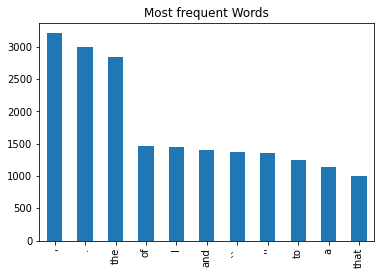

In [ ]:
# Plot most frequent words
def plot_frequency(df, column, num_values_in_bar_plot=11):
    '''
    Generic function for plotting the most frequent
    occurences of a column from the dataframe
    :param df: Dataframe
    :param column: column from Dataframe
    :num_values_in_bar_plot=11: (+1 since start at 0), how many should be plotted
    '''
    word_counts = df[column].value_counts()
    plot_word = word_counts[0:num_values_in_bar_plot]
    plot_word.plot(title = 'Most frequent ' + column + 's', kind='bar')

plot_frequency(df_train, 'Word')

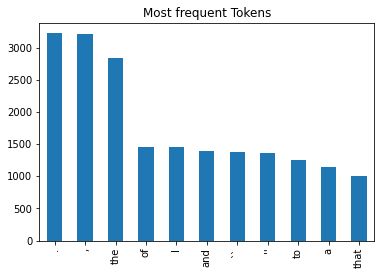

In [ ]:
plot_frequency(df_train, 'Token')

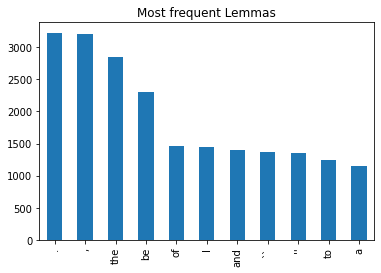

In [ ]:
plot_frequency(df_train, 'Lemma')

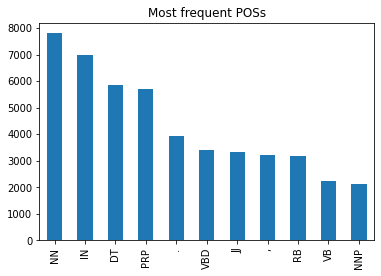

In [ ]:
plot_frequency(df_train, 'POS')

In [ ]:
df_train.head(30)

,Text,Sentence,Word_N,Word,Label,Token,id,POS,Lemma,Label_Bigram,Label_Trigram
0,baskervilles01,0,0,Chapter,O,Chapter,baskervilles01_0,NN,Chapter,"(O, O)","(O, O, O)"
1,baskervilles01,0,1,1.,O,1,baskervilles01_0,CD,1,"(O, O)","(O, O, O)"
2,baskervilles01,0,1,1.,O,.,baskervilles01_0,.,.,"(O, O)","(O, O, O)"
3,baskervilles01,0,2,Mr.,O,Mr,baskervilles01_0,NNP,Mr,"(O, O)","(O, O, O)"
4,baskervilles01,0,2,Mr.,O,.,baskervilles01_0,.,.,"(O, O)","(O, O, O)"
5,baskervilles01,0,3,Sherlock,O,Sherlock,baskervilles01_0,NNP,Sherlock,"(O, O)",None
6,baskervilles01,0,4,Holmes,O,Holmes,baskervilles01_0,NNP,Holmes,None,None
7,baskervilles01,1,0,Mr.,O,Mr,baskervilles01_1,NNP,Mr,"(O, O)","(O, O, O)"
8,baskervilles01,1,0,Mr.,O,.,baskervilles01_1,.,.,"(O, O)","(O, O, O)"
9,baskervilles01,1,1,Sherlock,O,Sherlock,baskervilles01_1,NNP,Sherlock,"(O, O)","(O, O, O)"


In [ ]:
BNEG=[]
INEG=[]

for i in range(len(df_train)):
    # Checks for combination 'B-NEG' and 'I-NEG'
    if df_train['Label'][i] == 'B-NEG' and "I-NEG" in df_train['Label_Bigram'][i]:
        INEG.append(df_train['POS'][i])
        print('B I neg', df_train['POS'][i], df_train['Token'][i])
    elif df_train['Label'][i] == 'B-NEG':
        BNEG.append(df_train['POS'][i])
        print('B neg', df_train['POS'][i], df_train['Token'][i])
    elif df_train['Label'][i] == 'I-NEG':
        INEG.append(df_train['POS'][i])
        print('I neg', df_train['POS'][i], df_train['Token'][i])
    else:
        pass
        
counted_bneg = Counter(BNEG)
counted_ineg = Counter(INEG)

B neg VBP save
B neg RB not
B neg JJ infrequent
B neg DT no
B neg JJ unfortunate
B neg DT no
B neg RB not
B neg IN without
B neg RB never
B neg NN nothing
B neg RB Not
B neg UH No
B neg DT no
B neg RB not
B I neg IN by
I neg DT no
I neg NNS means
B neg JJ unknown
B neg RB none
B neg RB not
B neg RB not
B neg RB not
B neg JJ unambitious
B neg RB incredulously
B neg DT no
B neg RB not
B neg DT No
B neg JJ unambitious
B neg JJ unambitious
B neg RB not
B neg RB not
B neg RB n't
B neg RB not
B neg RB not
B neg RB not
B neg RB not
B neg JJ unknown
B neg RB not
B neg RB No
B neg RB not
B neg DT no
B neg RB not
B neg DT No
B neg DT no
B neg JJ unpractical
B neg RB not
B neg RB not
B neg RB inadvertently
B neg RB not
B neg JJ unimaginative
B neg DT no
B neg RB not
B neg RB not
B neg CC nor
B neg JJ godless
B neg RB never
B neg JJ unable
B neg JJ unhappy
B I neg IN by
I neg DT no
I neg NNS means
B neg JJ unhappy
B neg RB not
B neg CC nor
B neg CC Nor
B neg JJ unhappy
B neg JJ infinite
B neg RB n

In [ ]:
counted_bneg = dict(sorted(counted_bneg.items(), reverse=True, key=lambda item: item[1]))
print(len(BNEG))
print(len(INEG))

979
24


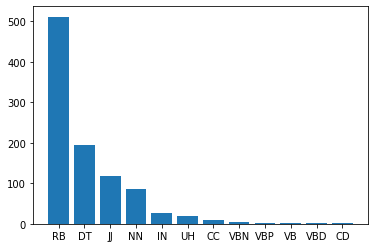

In [ ]:
keys = counted_bneg.keys()
values = counted_bneg.values()
plt.bar(keys, values)
plt.show()

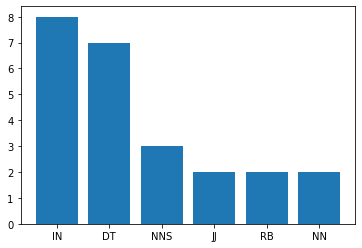

In [ ]:
keys = counted_ineg.keys()
values = counted_ineg.values()
plt.bar(keys, values)
plt.show()

In [ ]:
all_pos = []

for i in range(len(df_train)):
    all_pos.append(df_train['POS'][i])

all_counted = Counter(all_pos)
print(all_counted)

Counter({'NN': 7803, 'IN': 6999, 'DT': 5842, 'PRP': 5709, '.': 3917, 'VBD': 3417, 'JJ': 3334, ',': 3208, 'RB': 3161, 'VB': 2238, 'NNP': 2120, 'CC': 2022, 'PRP$': 1653, 'NNS': 1538, 'VBN': 1425, '``': 1405, "''": 1383, 'VBP': 1309, 'TO': 1272, 'MD': 1111, 'VBZ': 1089, 'VBG': 739, 'WDT': 404, 'WP': 375, 'CD': 371, 'WRB': 369, 'RP': 306, 'EX': 242, ':': 212, 'POS': 155, 'JJR': 132, 'RBR': 93, 'UH': 92, 'PDT': 83, 'JJS': 71, 'RBS': 43, 'NNPS': 10, 'FW': 9, 'WP$': 6, '(': 5, ')': 5})


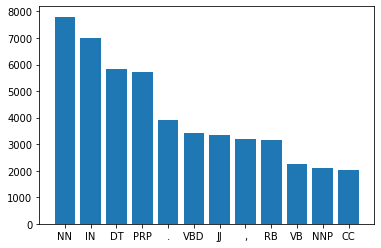

In [ ]:
keys = dict(all_counted.most_common(12)).keys()
values = dict(all_counted.most_common(12)).values()
plt.bar(keys, values)
plt.show()

# Feature Extraction

NOTE: please run the Data Preprocessing steps before continueing here.

## Extra preprocessing: deletions

In [ ]:
def stopword_removal(df):
    '''
    Function that will remove all english stopwords from the dataframe according to the nltk corpus stopword selection.
    '''
    df["Is_stopword"] = df["Token"].apply(lambda x: 1 if x in stopwords.words('english') else 0)
    df = df.drop(df[df.Is_stopword==1].index).reset_index(drop=True)
    return df

def punctuation_removal(df):
    '''
    This function will remove punctuation from the dataframe.
    '''
    df["Is_punct"] = df["Token"].apply(lambda x: 0 if x.isalnum() else 1)
    df = df.drop(df[df.Is_punct==1].index).reset_index(drop=True)
    return df

def preprocessing(df, do_stopword_removal = False, do_punctuation_removal = False):
    '''
    Here can be specified whether the stopword and punctuation removal should be performed.
    '''
    if do_stopword_removal:
        df = stopword_removal(df)
        df.drop(['Is_stopword'], axis=1)
    if do_punctuation_removal:
        df = punctuation_removal(df)
        df.drop(['Is_punct'], axis=1)

    #text = get_all_sentences(df)

    return df#, text

# run only once
df_train = preprocessing(df_train, do_stopword_removal=True, do_punctuation_removal=True)#, do_stopword_removal=True, do_punctuation_removal=True)

df_dev = preprocessing(df_dev, do_stopword_removal=True, do_punctuation_removal=True)#, do_stopword_removal=True, do_punctuation_removal=True)

## Utility Functions

In [ ]:
def get_wordnet_pos(treebank_tag):
    '''
    Checks the NTLK POS tag / Treebank tag with that of the Wordnet POS tags

    :param treebank_tag: the tag to be checked.
    :return: the corresponding wordnet tag if there is one, otherwise 0.
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return "null"


def lemmatize_text(token, pos):
    '''
    Lemmatizes each token within the dataframe, if the POS tag is recognized by Wordnet.
    Otherwise, it will simply return the original token.

    :param token: The token to be lemmatized
    :param pos: The corresponding pos tag of the token
    :return: the original token or the lemmatized token, depending on the POS tag
    '''
    lemmatizer = WordNetLemmatizer()
    return  lemmatizer.lemmatize(token, pos=get_wordnet_pos(pos)) if  get_wordnet_pos(pos) is not "null" else token 


def process_tf_idf_scores(score_dict, text,token):
    '''
    Adds TF-IDF scores to DataFrame

    :param score_dict: A dict of scores for each token for each text
    :param text: The text for which the token was evaluated
    :param token: the token for which the score should be applied

    :return binary feature whether the token exists in the score_dict, 1 if it exists, 0 otherwise.
    '''
    new_dict = score_dict[text]
    return 0 if token not in new_dict else new_dict[token]
    

def flatten(text):
    '''
    Flattens the list so that every item is a word and not a sentence

    :param text: the text divided by sentences to flatten.
    :return flat: the flattened list.
    '''
    flat = [word for sentence in text for word in sentence]
    return flat


def get_all_labels(df):
  
    df["id"] = df["Text"]+ "_" +df["Sentence"].astype(str)
    unique_ids = df["id"].unique()
    text = []
    for id in unique_ids:
        sentence = [token for token in df.loc[df["id"] == id]["Label"]]
        text.append(sentence)
    return text


def character_ngrams(token, length, num):
    '''
    This function creates character n-grams for a specific input token.

    :param token: the token for which the n-grams are created.
    :param length: number of characters per n-gram.
    :param num: how many n-grams are shown from beginning and ending of a word.
    :return: The updated dataframe.
    '''
    chrs = [c for c in token]
    if len(chrs)>((length*2)+1):
        pre = list(ngrams(chrs,length))[0:num]
        post = list(ngrams(chrs,length))[-num:]
        char_n_gram = pre + post
        return char_n_gram
    return ["null"]*num*2   


def add_wordnet_count_features(lemma, exists):
    '''
    Adds all wordnet count features for a given lemma
    This includes synonyms, hypernymns, hyponyms holonyms, root_hypernyms
    Check https://www.nltk.org/howto/wordnet.html for examples on how this works

    :param lemma: The lemma for which the synsets are checked
    :param exists: checks if the lemma exists in wordnet

    :return number of synonyms for the given lemma
    '''

    if exists == 1: # There is a wordnet pos tag present
        list_of_features = []
        synsets = wordnet.synsets(lemma) # In case there was an error in the previous lemma step
        lemma_synset = synsets[0].lemmas()[0]

        list_of_features.append( len(synsets) -1 ) #synonym length, -1 since that is the word itself
        list_of_features.append( len( lemma_synset.hypernyms() ) ) 
        list_of_features.append( len( lemma_synset.hyponyms() ) )
        list_of_features.append( len( lemma_synset.member_holonyms() ) )
        list_of_features.append( len( lemma_synset.antonyms()))

        return pd.Series(list_of_features) 

    else:

        return pd.Series( [0] * 5 )


def create_affix_features(lemma):

    if any(prefix in lemma[0:len(prefix)] for prefix in negative_prefixes ):
        list_of_features = [1,0]
        lemma_prefix = [prefix for idx,prefix in enumerate(negative_prefixes) if prefix in lemma][0]

        if lemma_prefix == "a":
            new_lemma = lemma[1:]
        else:
            new_lemma = lemma.replace( lemma_prefix, "" )

    elif "less" in lemma[-4:] :
        list_of_features = [0,1] 
        new_lemma = lemma.replace("less", "")
    
    elif "lessness" in lemma[-8:]:
        list_of_features =  [0,1] 
        new_lemma = lemma.replace("lessness", "")
         
    else:
        return pd.Series( [0] * 4 )

    synsets = wordnet.synsets(new_lemma)

    if synsets:
        list_of_features.append(1)
        lemma_antonyms = synsets[0].lemmas()[0].antonyms()
        list_of_antonyms = [ant.name().split(".")[0] for ant in lemma_antonyms]

        if lemma in list_of_antonyms:
            list_of_features.append(1)
        else:
            list_of_features.append(0)
    
    else:
        list_of_features.extend( [0] * 2)

    return pd.Series( list_of_features )



## The better known feature extraction functions

In [ ]:
def basic_features(df,text):
    '''
    Creates all "basic'' or novel features for the dataframe.
    These features are generally related to POS tag and Lemma or the Span of the token w.r.t. the sentence.

    :param df: The dataframe to which to add the features
    :param text: A list of sentences, where each sentence is a list of token
    :return: The updated dataframe
    '''
    global pos_text

    token_idcs = [idx for sent in text for idx,token in enumerate(sent)]

    pos_text = pos_tag_sents(text)
    pos_tags = [pos[1] for sent in pos_text for pos in sent]

    spans_per_sent = [ list( w_tokenizer.span_tokenize( str(sent) ) ) for sent in text ]
    spans = [span for sent in spans_per_sent for span in sent]
    max_spans = [max(sent) for sent in spans_per_sent for token in sent]

    df["Token_N"] = token_idcs
    #df['POS text'] = pos_text
    df["POS"] = pos_tags
    df["Span"] = spans
    df["Span_max"] = max_spans
    df["Lemma"] = df.apply( lambda x: lemmatize_text( x["Token"] , x["POS"]) , axis =1).astype(str)

    df["Has_wordnet_pos"] = df["POS"].apply(lambda x: 0 if get_wordnet_pos(x) == "null" else 1)
    df["Wordnet_pos"] = df["POS"].apply(lambda x: get_wordnet_pos(x) )
    
    df["Token_length"] = df["Lemma"].apply(lambda x: len(x))
    df["Has_uppercase"] =  df["Lemma"].apply(lambda x: 1 if any( xi.isupper() for xi in x ) else 0)

    return df


def create_token_features(df,text):
    '''
    Creates features based on the token or lemma, such as token count

    :param df: The dataframe to which to add the features
    :param text: A list of sentences, where each sentence is a list of token
    :return: The updated dataframe
    '''

    from collections import Counter

    #token_list = [token for sent in text for token in sent]
    token_list = df["Lemma"].to_list()
    token_list_with_wordnet_pos = list( df.loc[df["Wordnet_pos"] != "null"]["Lemma"].unique() )

    token_dict = dict(Counter(token_list))
    word_dict = df["Word"].value_counts().to_dict()

    df["Total_lemma_count"] = df["Lemma"].apply(lambda x: token_dict[x])
    df["Total_word_count"] = df["Word"].apply(lambda x: word_dict[x])

    token_dict_wordnet_pos = token_dict

    for key in list( token_dict_wordnet_pos.keys() ):
        if key not in token_list_with_wordnet_pos:
            del token_dict_wordnet_pos[key]

    most_popular_tokens = dict( Counter(token_dict_wordnet_pos).most_common(20) )

    df["Is_popular_token"] = df["Lemma"].apply( lambda x: 1 if x in most_popular_tokens else 0)

    return df

def create_sent_features(df,text):
    '''
    Creates features based on the sentence, such as sentence length through token count.

    :param df: The dataframe to which to add the features
    :param text: A list of sentences, where each sentence is a list of token
    :return: The updated dataframe
    '''

    sentence_count = [elem  for sent in text for elem in [len(sent)] * len(sent)]
    average_length = np.mean(sentence_count)
    df["Sentence_token_count"] = sentence_count

    df["Is_begin_token"] = df["Span"].apply( lambda x: 1 if x[0] == 0 else 0)
    df["Is_end_token"] = df[["Span", "Span_max"]].apply( lambda x: 1 if x["Span"] == x["Span_max"] else 0, axis =1 )

    #check if the sentence is short based on average sentence length
    df["Is_short_sentence"] = df["Sentence_token_count"].apply(lambda x : 1 if x < average_length else 0)

    # check if token is in the earlier or later half of the sentence
    df["Is_early_token"] = df.apply(lambda x : 1 if x["Token_N"] < (x["Sentence_token_count"]/2) else 0  , axis = 1)

    return df

def create_gram_features(df, text, n_grams=[2,3,4,5]):
    ''' 
    This function creates n-grams for all tokens with their context.

    :param df: The dataframe to which to add the features
    :param text: A list of sentences, where each sentence is a list of token
    :param n_grams: Specifies what kind of word n_grams we want to use.
    :return: The updated dataframe
    '''

    text_flat = ' '.join(flatten(text))
    for n in n_grams:
        ngrams = list(nltk.ngrams(text_flat.split(), n))
        ngrams.extend([None]*(n-1))
        df[f"W_{n}-gram"] = ngrams
    for n in n_grams:
        df[f'W_{n}-gram-1'] = df[f'W_{n}-gram'].shift(n-1)
    return df

def create_character_ngrams(df, length, num):
    '''
    This function creates character n-grams for all tokens.

    :param df: The dataframe to which to add the features.
    :param length: number of characters per n-gram.
    :param num: how many n-grams are shown from beginning and ending of a word.
    :return: The updated dataframe
    '''
    char_grams = df["Token"].apply(lambda token: character_ngrams(token, length, num))
    for i in range(num):
        df[f"char_{length}-gram({i})"] = char_grams.str[i]
    for i in range(num):
        df[f"char_{length}-gram({(2*num)-i})"] = char_grams.str[-(i+1)]
    return df


## The newer and more advanced feature functions

In [ ]:
def create_grammar_phrases(df,lst):
    tagdict = load('help/tagsets/upenn_tagset.pickle')

    grammar = r"""
      NP: {<DT|JJ|NN.*>+}          # Chunk sequences of DT, JJ, NN
      PP: {<IN><NP>}               # Chunk prepositions followed by NP
      VP: {<VB.*><NP|PP|CLAUSE>+$} # Chunk verbs and their arguments
      CLAUSE: {<NP><VP>}           # Chunk NP, VP
      """
    cp = nltk.RegexpParser(grammar)

    token_phrases_tuple = []

    for index in lst:
        result = cp.parse(index)

        for i in result:
            if '/' in str(i):
                i_split = str(i).split("(")
                current_phrases = []
                for s in i_split[1:]:
                    new_split = s.split(" ")
                    new_phrase = new_split[0]
                    current_phrases.append(new_phrase)

                    for s2 in new_split[1:]:
                        if s2 == '':
                            continue
                        token_phrases_tuple.append( (deepcopy(current_phrases)))
            else:
                token_phrases_tuple.append("null")
                
    df['Grammar phrases'] = token_phrases_tuple
    
    return df

def perform_named_entity_recognition(df, text):
    '''
    Perform NER on the text and update the dataframe.
    The features added are the label and a binary variable of whether a NER label exists.

    :param df: The dataframe to which to add the features
    :param text: A list of sentences, where each sentence is a list of token
    :return: The updated dataframe
    '''

    list_of_all_nes = []

    for sentence in text:
        list_of_nes = []

        for chunk in nltk.ne_chunk(nltk.pos_tag(sentence)):

            if hasattr(chunk, 'label'):
                token = ' '.join(c[0] for c in chunk) 

                if token not in sentence:
                    labels = [chunk.label() for x in token.split()]
                    list_of_nes.extend(labels)

                else:
                    list_of_nes.append(chunk.label())

            else:
                list_of_nes.append("null")

        list_of_all_nes.extend(list_of_nes)

    df["Named_Entity"] = list_of_all_nes
    df["Has_Named_Entity"] = df["Named_Entity"].apply( lambda x : 1 if x != "null" else 0)

    return df

def get_tfidf_scores(df):
    '''
    Uses the sk-learn library to get the TF-IDF scores for each feature per document

    :param df: The dataframe with features
    :return: The updated dataframe
    '''

    unique_ids = df["Text"].unique()

    full_text = []

    for text_id in unique_ids:
        text = []
        text_df = df.loc[ df["Text"] == text_id]
        unique_sentences = text_df["Sentence"].unique()

        for sent in unique_sentences:
            sentence = ' '.join( text_df.loc[text_df["Sentence"] == sent]["Token"] ) 
            text.append(sentence)

        document = ' '.join(text)
        full_text.append(document)

    tf_transformer = TfidfVectorizer(use_idf=True)
    tf_idf_obj = tf_transformer.fit_transform(np.asarray(full_text))
    tf_idf_array = tf_idf_obj.toarray()
    feature_names = tf_transformer.get_feature_names_out()

    tf_idf_dict = { unique_ids[idx] : dict(zip(feature_names, document)) for idx,document in enumerate( tf_idf_array ) }
    df["TF-IDF score"] = df.apply( lambda x : process_tf_idf_scores(tf_idf_dict,x["Text"], x["Token"]), axis = 1)

    return df

def process_wordnet_features(df):
    '''
    Creates various wordnet features for the given dataframe

    :param df: The dataframe with features
    :return: The updated dataframe
    '''

    df["Synset_exists"] = df["Lemma"].apply( lambda x: 1 if wordnet.synsets(x) else 0)

    df[["Has_possible_prefix", "Has_subfix", "Has_correlating_synonym", "Has_correct_antonym"]] = \
            df["Lemma"].apply( lambda x : create_affix_features(x) )


    df[["Synset_count", "Hypernym_count", "Hyponym_count", "Holonym_count", "Antonym_count"]] =  \
        df[["Lemma", "Synset_exists"]].apply( lambda x: add_wordnet_count_features(x["Lemma"], x["Synset_exists"]), axis =1)

    df["Has_antonyms"] = df["Antonym_count"].apply( lambda x: 1 if x > 0 else 0 )
    
    return df

In [ ]:
df_train.head()

,Text,Sentence,Word_N,Word,Label,Token,id,POS,Lemma,Label_Bigram,Label_Trigram,Is_stopword,Is_punct
0,baskervilles01,0,0,Chapter,O,Chapter,baskervilles01_0,NN,Chapter,"(O, O)","(O, O, O)",0,0
1,baskervilles01,0,1,1.,O,1,baskervilles01_0,CD,1,"(O, O)","(O, O, O)",0,0
2,baskervilles01,0,2,Mr.,O,Mr,baskervilles01_0,NNP,Mr,"(O, O)","(O, O, O)",0,0
3,baskervilles01,0,3,Sherlock,O,Sherlock,baskervilles01_0,NNP,Sherlock,"(O, O)",None,0,0
4,baskervilles01,0,4,Holmes,O,Holmes,baskervilles01_0,NNP,Holmes,None,None,0,0


## Feature extraction overview

NOTE: First run the Data Preprocessing before running this, otherwise, it will give an error

NOTE 2: It takes approximately 80-100 seconds to create all the features, be patient, since a lot is going on in the background!

In [ ]:
def add_features(df, text):
    '''
    Adds allf eatures to the dataframe, using the functions described previously.

    :param df: The dataframe to which to add the features
    :param text: A list of sentences, where each sentence is a list of token
    :return: The updated dataframe
    '''
    df = basic_features(df,text)
    df = create_token_features(df,text)
    df = create_sent_features(df,text)

    df = create_gram_features(df,text, n_grams=[2,3,4,5]) 
    df = create_character_ngrams(df, length=2, num=3)
    df = create_character_ngrams(df, length=3, num=3)
    
    df = create_grammar_phrases(df,pos_text)
    df = get_tfidf_scores(df)
    df = perform_named_entity_recognition(df,text)
    df = process_wordnet_features(df)

    return df

df_train = add_features(df_train, get_all_sentences(df_train))


In [ ]:
df_train.head()

,Text,Sentence,Word_N,Word,Label,Token,id,POS,Lemma,Label_Bigram,Label_Trigram,Is_stopword,Is_punct,Token_N,Span,Span_max,Has_wordnet_pos,Wordnet_pos,Token_length,Has_uppercase,Total_lemma_count,Total_word_count,Is_popular_token,Sentence_token_count,Is_begin_token,Is_end_token,Is_short_sentence,Is_early_token,W_2-gram,W_3-gram,W_4-gram,W_5-gram,W_2-gram-1,W_3-gram-1,W_4-gram-1,W_5-gram-1,char_2-gram(0),char_2-gram(1),char_2-gram(2),char_2-gram(6),char_2-gram(5),char_2-gram(4),char_3-gram(0),char_3-gram(1),char_3-gram(2),char_3-gram(6),char_3-gram(5),char_3-gram(4),Grammar phrases,TF-IDF score,Named_Entity,Has_Named_Entity,Synset_exists,Has_possible_prefix,Has_subfix,Has_correlating_synonym,Has_correct_synonym,Synset_count,Hypernym_count,Hyponym_count,Holonym_count,Antonym_count,Has_antonyms
0,baskervilles01,0,0,Chapter,O,Chapter,baskervilles01_0,NN,Chapter,"(O, O)","(O, O, O)",0,0,0,"(0, 11)","(35, 44)",1,n,7,1,14,14,0,5,1,0,1,1,"(Chapter, 1)","(Chapter, 1, Mr)","(Chapter, 1, Mr, Sherlock)","(Chapter, 1, Mr, Sherlock, Holmes)",NaN,NaN,NaN,NaN,"(C, h)","(h, a)","(a, p)","(e, r)","(t, e)","(p, t)",null,null,null,null,null,null,[NP],0.0,null,0,1,0,0,0,0,4,0,0,0,0,0
1,baskervilles01,0,1,1.,O,1,baskervilles01_0,CD,1,"(O, O)","(O, O, O)",0,0,1,"(12, 16)","(35, 44)",0,null,1,0,1,1,0,5,0,0,1,1,"(1, Mr)","(1, Mr, Sherlock)","(1, Mr, Sherlock, Holmes)","(1, Mr, Sherlock, Holmes, Mr)","(Chapter, 1)",NaN,NaN,NaN,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,0,1,0,0,0,0,1,0,0,0,0,0
2,baskervilles01,0,2,Mr.,O,Mr,baskervilles01_0,NNP,Mr,"(O, O)","(O, O, O)",0,0,2,"(17, 22)","(35, 44)",1,n,2,1,62,62,0,5,0,0,1,1,"(Mr, Sherlock)","(Mr, Sherlock, Holmes)","(Mr, Sherlock, Holmes, Mr)","(Mr, Sherlock, Holmes, Mr, Sherlock)","(1, Mr)","(Chapter, 1, Mr)",NaN,NaN,null,null,null,null,null,null,null,null,null,null,null,null,[NP],0.0,null,0,1,0,0,0,0,0,0,0,0,0,0
3,baskervilles01,0,3,Sherlock,O,Sherlock,baskervilles01_0,NNP,Sherlock,"(O, O)",None,0,0,3,"(23, 34)","(35, 44)",1,n,8,1,33,33,0,5,0,0,1,0,"(Sherlock, Holmes)","(Sherlock, Holmes, Mr)","(Sherlock, Holmes, Mr, Sherlock)","(Sherlock, Holmes, Mr, Sherlock, Holmes)","(Mr, Sherlock)","(1, Mr, Sherlock)","(Chapter, 1, Mr, Sherlock)",NaN,"(S, h)","(h, e)","(e, r)","(c, k)","(o, c)","(l, o)","(S, h, e)","(h, e, r)","(e, r, l)","(o, c, k)","(l, o, c)","(r, l, o)",[NP],0.0,null,0,1,0,0,0,0,0,0,0,0,0,0
4,baskervilles01,0,4,Holmes,O,Holmes,baskervilles01_0,NNP,Holmes,None,None,0,0,4,"(35, 44)","(35, 44)",1,n,6,1,189,189,1,5,0,1,1,0,"(Holmes, Mr)","(Holmes, Mr, Sherlock)","(Holmes, Mr, Sherlock, Holmes)","(Holmes, Mr, Sherlock, Holmes, usually)","(Sherlock, Holmes)","(Mr, Sherlock, Holmes)","(1, Mr, Sherlock, Holmes)","(Chapter, 1, Mr, Sherlock, Holmes)","(H, o)","(o, l)","(l, m)","(e, s)","(m, e)","(l, m)",null,null,null,null,null,null,[NP],0.0,null,0,1,0,0,0,0,3,0,0,0,0,0
